 ## Import the libraries

 ---

In [1]:
# !pip install pandas==0.23.4

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import rcParams
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
import scipy.stats


from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

## Loading the data

---

In [3]:
df = pd.read_csv('/content/weather-sa-2017-2019-clean.csv')
df.shape

(249023, 15)

In [4]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df)
profile

Number of variables,15
Number of observations,249023
Total Missing (%),0.0%
Total size in memory,28.5 MiB
Average record size in memory,120.0 B
Numeric,10
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [5]:
df.head()

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,0,Qassim,1 January 2017,00:00,2017,1,1,24,0,Clear,17,11,64%,1018.0,16
1,1,Qassim,1 January 2017,01:00,2017,1,1,1,0,Clear,17,6,64%,1018.0,16
2,2,Qassim,1 January 2017,03:00,2017,1,1,3,0,Clear,15,11,72%,1019.0,16
3,3,Qassim,1 January 2017,04:00,2017,1,1,4,0,Clear,15,11,72%,1019.0,16
4,4,Qassim,1 January 2017,05:00,2017,1,1,5,0,Clear,15,9,72%,1019.0,16


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249023 entries, 0 to 249022
Data columns (total 15 columns):
Unnamed: 0    249023 non-null int64
city          249023 non-null object
date          249023 non-null object
time          249023 non-null object
year          249023 non-null int64
month         249023 non-null int64
day           249023 non-null int64
hour          249023 non-null int64
minute        249023 non-null int64
weather       249023 non-null object
temp          249023 non-null int64
wind          249023 non-null int64
humidity      249006 non-null object
barometer     248951 non-null float64
visibility    249023 non-null int64
dtypes: float64(1), int64(9), object(5)
memory usage: 28.5+ MB


## data cleaning

---

In [7]:
# convert date to datetime type
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249023 entries, 0 to 249022
Data columns (total 15 columns):
Unnamed: 0    249023 non-null int64
city          249023 non-null object
date          249023 non-null datetime64[ns]
time          249023 non-null object
year          249023 non-null int64
month         249023 non-null int64
day           249023 non-null int64
hour          249023 non-null int64
minute        249023 non-null int64
weather       249023 non-null object
temp          249023 non-null int64
wind          249023 non-null int64
humidity      249006 non-null object
barometer     248951 non-null float64
visibility    249023 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(4)
memory usage: 28.5+ MB


In [9]:
# Unnamed: 0 is irrlevent 
delete_col =['Unnamed: 0']
df.drop(delete_col, axis =1 , inplace =True)

In [10]:
# convert feature humidity to Numerical
df['humidity'] = df['humidity'].str.replace('%','').astype('float')

In [11]:
# Check duplicate 
duplicate = df.index.duplicated()
print('Number of duplicate =',duplicate.sum())

Number of duplicate = 0


In [12]:
df.isnull().sum()

city           0
date           0
time           0
year           0
month          0
day            0
hour           0
minute         0
weather        0
temp           0
wind           0
humidity      17
barometer     72
visibility     0
dtype: int64

Dealing with missing values

In [13]:
#   OR
# drop null in rows 
#df = df.dropna()
#df.isnull().sum()

In [14]:
# now filling the missing values with means for each city
df['humidity'] = df['humidity'].fillna(df.groupby('city')['humidity'].transform('mean'))

In [15]:
df['barometer'] = df['barometer'].fillna(df.groupby('city')['barometer'].transform('mean'))

In [16]:
df.isnull().sum()

city          0
date          0
time          0
year          0
month         0
day           0
hour          0
minute        0
weather       0
temp          0
wind          0
humidity      0
barometer     0
visibility    0
dtype: int64

In [17]:
df.describe()

,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility
count,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000,249023.000000
mean,2017.710007,6.050694,15.691081,12.536890,0.131108,24.722624,12.957104,37.553192,1015.454041,11.053453
std,0.706113,3.521591,8.787958,6.910254,1.970710,8.880913,8.711619,23.592329,6.970366,7.053005
min,2017.000000,1.000000,1.000000,1.000000,0.000000,-4.000000,-1.000000,0.000000,904.000000,-1.000000
25%,2017.000000,3.000000,8.000000,7.000000,0.000000,18.000000,7.000000,17.000000,1011.000000,5.000000
50%,2018.000000,6.000000,16.000000,13.000000,0.000000,24.000000,11.000000,32.000000,1016.000000,16.000000
75%,2018.000000,9.000000,23.000000,19.000000,0.000000,31.000000,19.000000,55.000000,1021.000000,16.000000
max,2019.000000,12.000000,31.000000,24.000000,59.000000,50.000000,163.000000,100.000000,1101.000000,161.000000


In [18]:
df['weather'].unique()

array(['Clear ', 'Sunny ', 'Scattered clouds ', 'Partly sunny ',
       'Passing clouds ', 'Refreshingly cool ', 'Low level haze ',
       'Duststorm ', 'Thunderstorms  Passing clouds ', 'Fog ',
       'Thunderstorms  Partly sunny ', 'Light rain  Partly sunny ',
       'Dense fog ', 'Thunderstorms  Scattered clouds ',
       'Rain  Passing clouds ', 'Extremely hot ', 'Rain  Partly sunny ',
       'Pleasantly warm ', 'Hot ', 'Mild ', 'Overcast ',
       'Rain  Overcast ', 'Smoke ', 'Thunderstorms  Broken clouds ',
       'Heavy rain  Partly sunny ', 'Thunderstorms  Overcast ',
       'Light rain  Overcast ', 'Warm ', 'Thunderstorms  Cloudy ',
       'Drizzle  Overcast ', 'Thunderstorms  Partly cloudy ',
       'Broken clouds ', 'Sandstorm ', 'Partly cloudy ', 'Mostly cloudy ',
       'Rain  Partly cloudy ', 'Rain  Broken clouds ',
       'Rain  Scattered clouds ', 'Haze ', 'Rain  Mostly cloudy ',
       'Hail  Partly sunny ', 'Thundershowers  Passing clouds ',
       'Thunderstorms  Mor

In [19]:
df.weather = df.weather.str.strip()
df.weather = df.weather.replace('\s+', ' ', regex=True)
df.weather = df.weather.str.title()
df.weather.unique()

array(['Clear', 'Sunny', 'Scattered Clouds', 'Partly Sunny',
       'Passing Clouds', 'Refreshingly Cool', 'Low Level Haze',
       'Duststorm', 'Thunderstorms Passing Clouds', 'Fog',
       'Thunderstorms Partly Sunny', 'Light Rain Partly Sunny',
       'Dense Fog', 'Thunderstorms Scattered Clouds',
       'Rain Passing Clouds', 'Extremely Hot', 'Rain Partly Sunny',
       'Pleasantly Warm', 'Hot', 'Mild', 'Overcast', 'Rain Overcast',
       'Smoke', 'Thunderstorms Broken Clouds', 'Heavy Rain Partly Sunny',
       'Thunderstorms Overcast', 'Light Rain Overcast', 'Warm',
       'Thunderstorms Cloudy', 'Drizzle Overcast',
       'Thunderstorms Partly Cloudy', 'Broken Clouds', 'Sandstorm',
       'Partly Cloudy', 'Mostly Cloudy', 'Rain Partly Cloudy',
       'Rain Broken Clouds', 'Rain Scattered Clouds', 'Haze',
       'Rain Mostly Cloudy', 'Hail Partly Sunny',
       'Thundershowers Passing Clouds',
       'Thunderstorms More Clouds Than Sun', 'More Clouds Than Sun',
       'Light Rain 

In [20]:
df.city.unique()

array(['Qassim', 'Hail', 'Madina', 'EP', 'Riyadh', 'Mecca', 'Tabuk',
       'Assir', 'Northern boarder', 'Jazan', 'Najran', 'Baha', 'Jawf'],
      dtype=object)

In [21]:
df.city.nunique()

13

In [22]:
s = df.groupby(['city'])['temp'].mean().nlargest(5)
s

city
Mecca     29.023239
Madina    28.708740
Riyadh    27.957981
EP        27.215077
Qassim    25.961350
Name: temp, dtype: float64

In [23]:
df2 = (df[df['city'].isin(s.index)]
               .groupby(['city', 'weather'])['temp']
               .size()
               .unstack(fill_value=0)
               .add_suffix(' days')
               .reindex(s.index)
               .reset_index()
               .rename_axis(None, axis=1))

df2.insert(1, 'temp avg', df2['city'].map(s))
df2.insert(0, 'rank', range(1, len(df2) + 1))
print (df2)

   rank    city    ...      Thunderstorms Scattered Clouds days  Warm days
0     1   Mecca    ...                                       11          4
1     2  Madina    ...                                        6          0
2     3  Riyadh    ...                                        1          0
3     4      EP    ...                                        9          5
4     5  Qassim    ...                                        8          1

[5 rows x 79 columns]


In [24]:
df2

,rank,city,temp avg,Broken Clouds days,Clear days,Cloudy days,Cool days,Dense Fog days,Drizzle Broken Clouds days,Drizzle Fog days,Drizzle More Clouds Than Sun days,Drizzle Mostly Cloudy days,Drizzle Overcast days,Drizzle Partly Sunny days,Duststorm days,Extremely Hot days,Fog days,Hail Cloudy days,Hail Partly Sunny days,Haze days,Heavy Rain More Clouds Than Sun days,Heavy Rain Mostly Cloudy days,Heavy Rain Overcast days,Heavy Rain Partly Sunny days,Hot days,Light Rain Broken Clouds days,Light Rain Fog days,Light Rain More Clouds Than Sun days,Light Rain Mostly Cloudy days,Light Rain Overcast days,Light Rain Partly Cloudy days,Light Rain Partly Sunny days,Light Rain Passing Clouds days,Light Rain Scattered Clouds days,Low Level Haze days,Mild days,More Clouds Than Sun days,Mostly Cloudy days,Overcast days,Partly Cloudy days,Partly Sunny days,Passing Clouds days,Pleasantly Warm days,Rain Broken Clouds days,Rain Clear days,Rain More Clouds Than Sun days,Rain Mostly Cloudy days,Rain Overcast days,Rain Partly Cloudy days,Rain Partly Sunny days,Rain Passing Clouds days,Rain Scattered Clouds days,Refreshingly Cool days,Sandstorm days,Scattered Clouds days,Smoke days,Sprinkles Cloudy days,Sprinkles Duststorm days,Sprinkles Low Level Haze days,Sprinkles Overcast days,Strong Thunderstorms Cloudy days,Strong Thunderstorms More Clouds Than Sun days,Strong Thunderstorms Partly Sunny days,Sunny days,Thundershowers Partly Sunny days,Thundershowers Passing Clouds days,Thundershowers Scattered Clouds days,Thunderstorms Broken Clouds days,Thunderstorms Cloudy days,Thunderstorms Fog days,Thunderstorms More Clouds Than Sun days,Thunderstorms Mostly Cloudy days,Thunderstorms Overcast days,Thunderstorms Partly Cloudy days,Thunderstorms Partly Sunny days,Thunderstorms Passing Clouds days,Thunderstorms Sandstorm days,Thunderstorms Scattered Clouds days,Warm days
0,1,Mecca,29.023239,32,7581,0,0,10,1,0,0,0,0,0,7,2,9,0,0,9,0,0,0,0,1,2,0,0,1,0,0,1,1,0,27,1,1,0,4,16,256,4457,0,1,0,0,0,0,0,2,2,1,0,60,1099,3,0,0,0,0,0,0,0,6524,5,17,3,4,0,0,0,0,1,1,30,81,0,11,4
1,2,Madina,28.708740,94,8668,0,0,1,0,0,0,0,0,0,156,5,14,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,2,4,15,3,14,215,2085,2,3,0,0,1,0,4,3,7,3,0,6,1023,0,0,0,0,0,0,0,0,7527,0,1,0,6,0,0,2,0,0,4,14,42,0,6,0
2,3,Riyadh,27.957981,378,7538,0,0,64,3,0,7,8,0,1,714,5,77,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,281,2,49,43,4,332,189,807,1,1,1,7,10,0,26,2,2,1,0,7,527,0,20,4,1,17,0,0,0,5074,0,2,0,6,0,0,2,32,1,90,5,46,2,1,0
3,4,EP,27.215077,259,8524,6,2,32,3,1,3,8,1,2,102,10,272,1,0,194,1,3,1,0,0,10,2,7,19,1,15,4,13,3,194,5,67,65,53,94,227,832,3,4,0,4,20,1,8,3,5,2,0,3,462,0,0,0,0,0,1,1,1,6772,0,0,0,14,1,2,12,39,8,29,15,45,0,9,5
4,5,Qassim,25.961350,4,6950,0,0,9,0,0,0,0,3,0,265,2,228,0,0,0,0,0,0,2,1,0,0,0,0,9,0,4,0,0,76,8,0,0,18,0,1099,2873,2,0,0,0,0,22,0,23,26,0,4,0,1004,5,0,0,0,0,0,0,0,6854,0,0,0,2,1,0,0,0,17,1,53,219,0,8,1


## Vesualiztion
---

In [25]:
#Quantitative variables:
quantitative = df[['temp', 'wind', 'humidity', 'barometer', 'visibility']]
print(quantitative)

        temp  wind  humidity  barometer  visibility
0         17    11      64.0     1018.0          16
1         17     6      64.0     1018.0          16
2         15    11      72.0     1019.0          16
3         15    11      72.0     1019.0          16
4         15     9      72.0     1019.0          16
5         13    13      82.0     1019.0          16
6         12     7      88.0     1019.0          16
7         14     9      72.0     1021.0          16
8         15     9      72.0     1021.0           7
9         17     7      64.0     1021.0           9
10        19    19      64.0     1021.0           7
11        20    19      60.0     1020.0          16
12        21    15      57.0     1020.0          16
13        22    15      53.0     1019.0          16
14        23    15      50.0     1018.0          16
15        22    22      53.0     1018.0          16
16        20    20      46.0     1018.0          16
17        19    19      49.0     1019.0          16
18        17

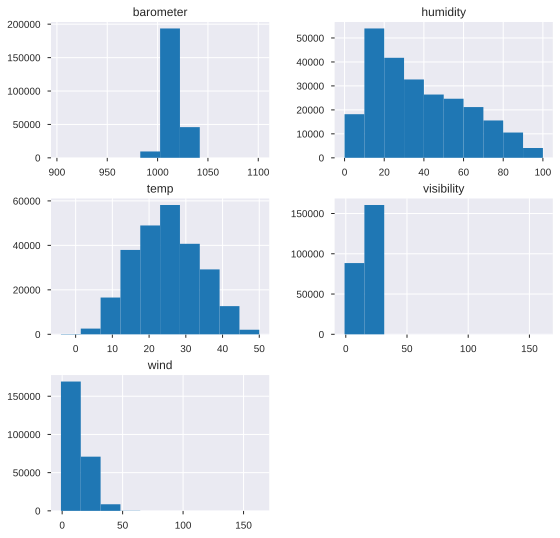

In [42]:
rcParams['figure.figsize'] = 9, 9
quantitative.hist();

In [27]:
#Drawing a heatmap
def facet_heatmap(df, color, **kws):
    values=df.columns.values[3]
    df = df.pivot(index='day', columns='hour', values=values)
    sns.heatmap(df, cmap='coolwarm', **kws)  

#Joining heatmaps of every month in a year 
def weather_calendar(year,weather): #Year= Any year in DataFrame. Weather=Any quantitative variable
    datayear = df[df['year']==year][['month', 'day', 'hour', weather]]
    vmin=datayear[weather].min()
    vmax=datayear[weather].max()
    with sns.plotting_context(font_scale=12):
        g = sns.FacetGrid(datayear,col="month", col_wrap=3) #One heatmap per month
        g = g.map_dataframe(facet_heatmap,vmin=vmin, vmax=vmax)
        g.set_axis_labels('Hour', 'Day')
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle('%s Calendar. Year: %s.' %(weather, year), fontsize=18)

In [28]:
weather_calendar(2017,'temp')

TypeError: ignored

In [31]:
year_humi = df.groupby(df.year).mean()
pd.stats.moments.ewma(year_humi.humidity, 5).plot()
year_humi.humidity.plot(linewidth=1)
plt.title('Saudi Average Humidity by year')
plt.xlabel('year')

AttributeError: ignored

## Target
---

In [32]:
df.weather.unique()

array(['Clear', 'Sunny', 'Scattered Clouds', 'Partly Sunny',
       'Passing Clouds', 'Refreshingly Cool', 'Low Level Haze',
       'Duststorm', 'Thunderstorms Passing Clouds', 'Fog',
       'Thunderstorms Partly Sunny', 'Light Rain Partly Sunny',
       'Dense Fog', 'Thunderstorms Scattered Clouds',
       'Rain Passing Clouds', 'Extremely Hot', 'Rain Partly Sunny',
       'Pleasantly Warm', 'Hot', 'Mild', 'Overcast', 'Rain Overcast',
       'Smoke', 'Thunderstorms Broken Clouds', 'Heavy Rain Partly Sunny',
       'Thunderstorms Overcast', 'Light Rain Overcast', 'Warm',
       'Thunderstorms Cloudy', 'Drizzle Overcast',
       'Thunderstorms Partly Cloudy', 'Broken Clouds', 'Sandstorm',
       'Partly Cloudy', 'Mostly Cloudy', 'Rain Partly Cloudy',
       'Rain Broken Clouds', 'Rain Scattered Clouds', 'Haze',
       'Rain Mostly Cloudy', 'Hail Partly Sunny',
       'Thundershowers Passing Clouds',
       'Thunderstorms More Clouds Than Sun', 'More Clouds Than Sun',
       'Light Rain 

In [33]:
df.weather.nunique()

81

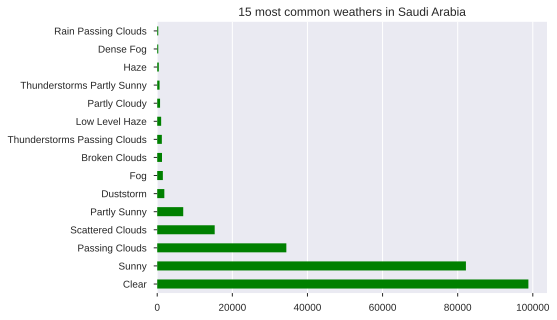

In [39]:
plt.figure(figsize=(7,5))
df['weather'].value_counts().head(15).plot(kind='barh', color= 'g')
plt.title('15 most common weathers in Saudi Arabia');
plt.grid(axis= 'y');

Clear and Sunny are most common weatehrs conditions in Saudi Arabia.

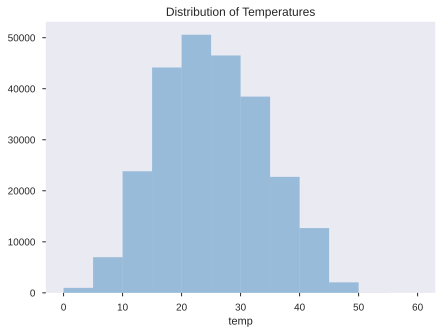

In [40]:
plt.figure(figsize=(7, 5))
sns.distplot(df['temp'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid();

Most common temperature scale in Saudi Arabia is from 20 to 25 degree.

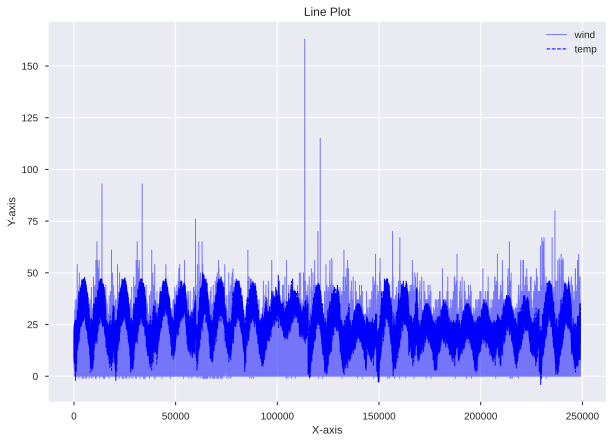

In [41]:
df.wind.plot(kind = 'line', color = "blue", label = "wind", figsize = (10,7),
                        linewidth = 1, alpha = 0.5, grid = True, linestyle = '-')

df.temp.plot(kind = 'line', color = "blue", label = "temp", figsize = (10,7),
                            linewidth = 1, alpha = 1, grid = True, linestyle = 'dashed')
plt.legend()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Line Plot")
plt.show()

## Time Series Analysis

---
